In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
tf.enable_eager_execution()

from model import *

Using TensorFlow backend.


In [3]:
from keras.datasets import mnist
import numpy as np
(X_train, y_train), (X_test, y_test) = mnist.load_data()

y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

print("Train data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)

print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train data shape: (60000, 28, 28)
Train labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


In [4]:
labels = range(10)
n_classes = len(labels)
print("Number of classes:", n_classes)
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,8))

n_columns = 12
n_rows = 4

for i in range(1,n_columns*n_rows+1):
  fig.add_subplot(n_rows, n_columns, i)
  plt.imshow(X_train[i])
  plt.title(labels[y_train[i]])
  # Turn off tick labels
  plt.xticks([])
  plt.yticks([])
plt.show(); None

Number of classes: 10


<Figure size 1800x800 with 48 Axes>

In [5]:
batch_size = 128


def normalizer(image, label):
    image = 2 * (tf.to_float(image)) / 255 - 1.
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(normalizer)
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size)

# train_dataset

In [6]:
def display_images(dataset, figsize=(6,6), denomalize=True):
    fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=figsize,)
    for ii, ax in enumerate(axes.flatten()):
        img = dataset[ii,:,:]
        if denomalize:
            img = ((img + 1)*255 / 2).astype(np.uint8) # Scale back to 0-255
        ax.imshow(img, aspect='equal')
      
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

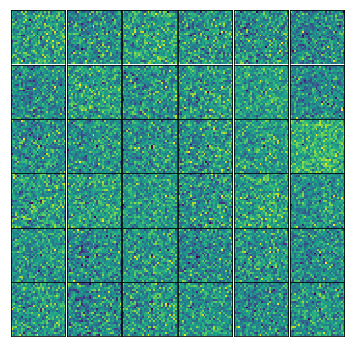

batch_count:  0 , epoch:  0 , g_loss:  0.69667953 , d_loss:  1.3934598


In [ ]:
from tensorflow.keras.layers import Dense, LeakyReLU, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.nn import leaky_relu, tanh, sigmoid
z_size = 128
learning_rate = 0.0002
alpha = 0.2
beta1 = 0.5
smooth=0.1

class Generator(tf.keras.Model):

    def __init__(self):
        super(Generator, self).__init__()
        n_features = z_size
        n_out = 28 * 28
        self.fc1 = Sequential([
            Dense(n_features, activation=None),
            LeakyReLU(alpha=0.2)
        ])
        self.fc2 = Sequential([
            Dense(n_features * 2, activation=None),
            LeakyReLU(alpha=0.2)
        ])
        self.fc3 = Sequential([
            Dense(n_features * 4, activation=None),
            LeakyReLU(alpha=0.2)
        ])
        self.out = Dense(n_out, activation=tanh)
    
    def call(self, z, is_training):
        fc1 = self.fc1(z)
        fc2 = self.fc2(fc1)
        fc3 = self.fc3(fc2)
        output = self.out(fc3)
        output = tf.reshape(output, (-1, 28, 28))
        return output
    
class Discriminator(tf.keras.Model):
    def __init__(self, alpha):
        super(Discriminator, self).__init__()
        n_input = 28 * 28
        n_features = 256
        self.fc1 = Sequential([
            Dense(n_input, activation=None),
            LeakyReLU(alpha=alpha),
            Dropout(0.3)
        ])
        self.fc2 = Sequential([
            Dense(n_features * 2, activation=None),
            LeakyReLU(alpha=alpha),
            Dropout(0.3)
        ])
        self.fc3 = Sequential([
            Dense(n_features, activation=None),
            LeakyReLU(alpha=alpha),
            Dropout(0.3)
        ])
        self.logits = Dense(1, activation=None)
        self.out = Activation(activation='sigmoid')
        
    def call(self, inputs, is_training):
        fc1 = self.fc1(inputs)
        fc2 = self.fc2(fc1)
        fc3 = self.fc3(fc2)
        logits = self.logits(fc3)
        output = self.out(logits)
        return output, logits
    
generator_net = Generator()
discriminator_net = Discriminator(alpha=alpha)

def discriminator_loss(d_logits_real, d_logits_fake, smooth=0.1):
  # for the real image from the training set, we want them to be classified as positives,  
  # so we want their labels to be all ones. 
  # notice here we use label smoothing for helping the discriminator to generalize better. 
  # Label smoothing works by avoiding the classifier to make extreme predictions when extrapolating.
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_logits_real) * (1 - smooth)
        )
    )

  # for the fake images produced by the generator, we want the discriminator to classify them as false images,
  # so we set their labels to be all zeros.
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.zeros_like(d_model_fake)
        )
    )
    d_loss = d_loss_real + d_loss_fake
    return d_loss
    
def generator_loss(d_logits_fake, d_model_fake):
    # since the generator wants the discriminator to output 1s for its images, it uses the discriminator logits for the
    # fake images and assign labels of 1s to them.
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.ones_like(d_model_fake)
        )
    ) 
    return g_loss

global_counter = tf.train.get_or_create_global_step()
generator_optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate, beta1=beta1
)
discriminator_optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate, beta1=beta1
)

# generate sample noise for evaluation
fake_input_test = tf.random_uniform(shape=(128, z_size),
                                 minval=-1.0, maxval=1.0, dtype=tf.float32)

for counter, (batch_real_images, batch_real_labels) in enumerate(train_dataset):
    fake_input = tf.random_uniform(shape=(batch_size, z_size),
                                 minval=-1.0, maxval=1.0, dtype=tf.float32)
  
  
    batch_real_images = tf.to_float(batch_real_images)
    with tf.GradientTape(persistent=True) as tape:

        # run the generator with the random noise batch
        g_model = generator_net(fake_input, is_training=True)

        # run the discriminator with real input images
        d_model_real, d_logits_real = discriminator_net(batch_real_images, is_training=True)

        # run the discriminator with fake input images (images from the generator)
        d_model_fake, d_logits_fake = discriminator_net(g_model, is_training=True)

        # compute the generator loss
        gen_loss = generator_loss(d_logits_fake, d_model_fake)

        # compute the discriminator loss
        dis_loss = discriminator_loss(d_logits_real, d_logits_fake, smooth)
        #print("Generator loss:", gen_loss, "Discriminator loss:", dis_loss)
    from IPython.display import clear_output

    if counter % 1000 == 0:
        generated_samples = generator_net(fake_input_test, is_training=False)
        clear_output()
        display_images(generated_samples.numpy())
        print('batch_count: ',counter, 
              ', epoch: ',  counter // len(X_train),
              ', g_loss: ', gen_loss.numpy(), ', d_loss: ', dis_loss.numpy())
    
    discriminator_grads = tape.gradient(dis_loss, discriminator_net.variables)
    generator_grads = tape.gradient(gen_loss, generator_net.variables)
    
    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator_net.variables), global_step=global_counter)
    generator_optimizer.apply_gradients(zip(generator_grads, generator_net.variables), global_step=global_counter)
    
    
    counter += 1